# Simple binary classifier
### With stopwords and doubled vocab size
This notebook shows a simple model inspired by the Tensorflow tutorial, using the datasets containing stopwords.

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

## Dataset
Load datasets

In [2]:
def load_data_arrays():
  df_1 = pd.read_csv("../../datasets/1_preprocessed.csv")
  df_3 = pd.read_csv("../../datasets/3_preprocessed.csv")
  df_5 = pd.read_csv("../../datasets/5_preprocessed.csv")
  df_6 = pd.read_csv("../../datasets/6_preprocessed.csv")

  df = df_1.append(df_3)
  df = df.append(df_5)
  df = df.append(df_6)

  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])

  return train_df, test_df

train_df, test_df = load_data_arrays()

Convert train and test datasets to Tensorflow datasets

In [3]:
train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
  tf.data.Dataset.from_tensor_slices(
    (
      tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
      tf.cast(train_labels, tf.int32)
    )
  )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
  tf.data.Dataset.from_tensor_slices(
    (
      tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
      tf.cast(test_labels, tf.int32)
    )
  )
)

Shuffle training data and create batches of (text, label) pairs

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model
### Create the text encoder
We create a text encoder using text vectorization. We define a vocabulary size of 1000 words and let Tensorflow create the vocabulary for this layer by adapting it to our dataset.

In [5]:
VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Create the model
We create a RNN model with different layers and let them process sequentially (because we have single input and output). At first, we create a numerical representation of the text using our encoder, which is transformed to an embedding. We then dense the output in 2 steps.

In [6]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 202,434
Trainable params: 202,434
Non-trai

### Compile the model
For the loss function we use binary cross entropy, since we have a binary classifier. We use a little learning rate of 0.01% in this first model, because it gives some good results.

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

### Train the model
We train the compiled model in 5 epochs. More epochs are not necessary because of decreasing improvements.

In [8]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
2717/2717 [==============================] - 116s 40ms/step - loss: 0.2573 - accuracy: 0.8957 - val_loss: 0.2137 - val_accuracy: 0.9203
Epoch 2/5
2717/2717 [==============================] - 107s 39ms/step - loss: 0.1738 - accuracy: 0.9337 - val_loss: 0.2064 - val_accuracy: 0.9172
Epoch 3/5
2717/2717 [==============================] - 106s 39ms/step - loss: 0.1681 - accuracy: 0.9347 - val_loss: 0.2034 - val_accuracy: 0.9141
Epoch 4/5
2717/2717 [==============================] - 106s 39ms/step - loss: 0.1655 - accuracy: 0.9353 - val_loss: 0.2020 - val_accuracy: 0.9156
Epoch 5/5
2717/2717 [==============================] - 107s 39ms/step - loss: 0.1630 - accuracy: 0.9356 - val_loss: 0.1995 - val_accuracy: 0.9172


### Test the model
We use our test dataset to verify the accuracy of our model.

In [9]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 11s 16ms/step - loss: 0.1730 - accuracy: 0.9316
Test Loss: 0.17302680015563965
Test Accuracy: 0.9316398501396179


Plot the results

(0.0, 0.2619978226721287)

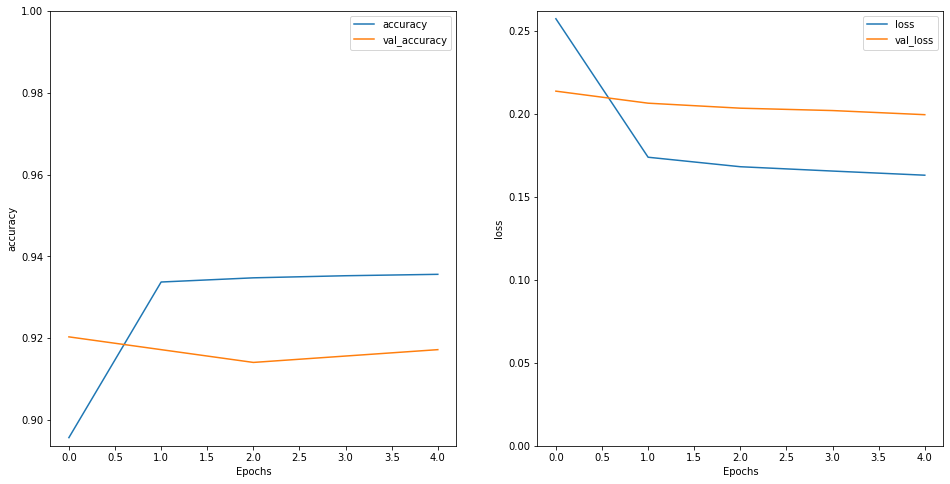

In [10]:
np.set_printoptions(precision=3, suppress=True)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Do a prediction to exemplary check the model. Results have the format [<probability_no_hate_speech>,<probability_hate_speech>]

In [11]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.998 0.002]
 [0.    1.   ]]


(Optional) Save the model for further usage

In [12]:
# model.save('saves/rnn_one', save_format='tf')

## Improved model
Try to improve the models accuracy by adding additional RNN layers.

In [13]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model_two.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          128000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

Compile and train the model with the same parameters as before

In [14]:
model_two.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

history_two = model_two.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
2717/2717 [==============================] - 212s 74ms/step - loss: 0.2610 - accuracy: 0.9001 - val_loss: 0.2000 - val_accuracy: 0.9245
Epoch 2/5
2717/2717 [==============================] - 196s 72ms/step - loss: 0.1812 - accuracy: 0.9329 - val_loss: 0.1923 - val_accuracy: 0.9292
Epoch 3/5
2717/2717 [==============================] - 196s 72ms/step - loss: 0.1742 - accuracy: 0.9344 - val_loss: 0.1916 - val_accuracy: 0.9281
Epoch 4/5
2717/2717 [==============================] - 196s 72ms/step - loss: 0.1707 - accuracy: 0.9345 - val_loss: 0.1916 - val_accuracy: 0.9234
Epoch 5/5
2717/2717 [==============================] - 197s 72ms/step - loss: 0.1682 - accuracy: 0.9352 - val_loss: 0.1941 - val_accuracy: 0.9245


Test the model

In [15]:
test_loss, test_acc = model_two.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 20s 30ms/step - loss: 0.1755 - accuracy: 0.9313
Test Loss: 0.1754857897758484
Test Accuracy: 0.931340754032135


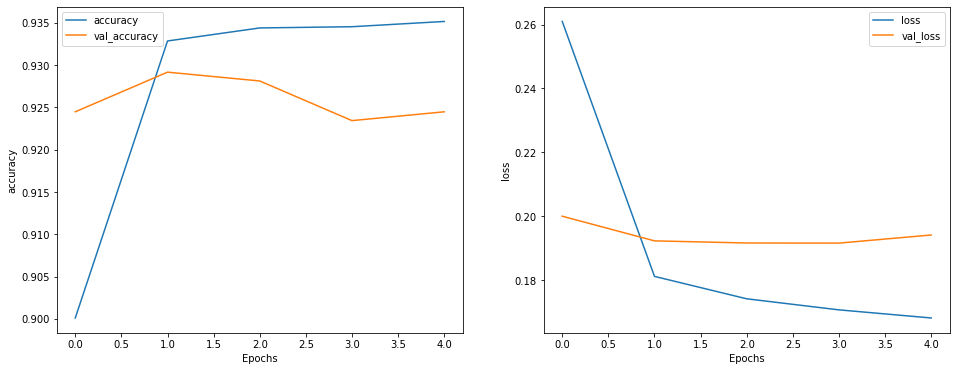

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_two, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_two, 'loss')

(Optional) Save the improved model

In [17]:
# model_two.save('saves/rnn_two')